#### 通过主成分分析进行无监督降维

关于特征选择和特征提取的区别：

* 特征选择：获取或者保留的是原始特征集合的一个子集，仍然是"original features"；
* 特征提取：是将待处理的数据集投影到一个新的特征空间。

特征提取可以理解为一种数据压缩方法，目的是保留大部分相关信息。在实践中，特征提取不仅用于改善存储空间或者学习算法的计算效率，还可以通过缓解维数灾难(curse of dimensionality)来提高预测性能，尤其是在使用正则化模型时。

#### 主成分分析(Principal component analysis, PCA)的主要步骤

无监督(unsupervised)的主成分分析方法, 帮助我们根据特征之间的相关性识别数据模式。简言之，PCA旨在找到高维数据中方差最大的方向，并将数据投影到与原始特征空间相同或更少的子空间上。

如下图所示，在新的特征轴相互正交的约束下，主成分可以理解为方差最大的方向：

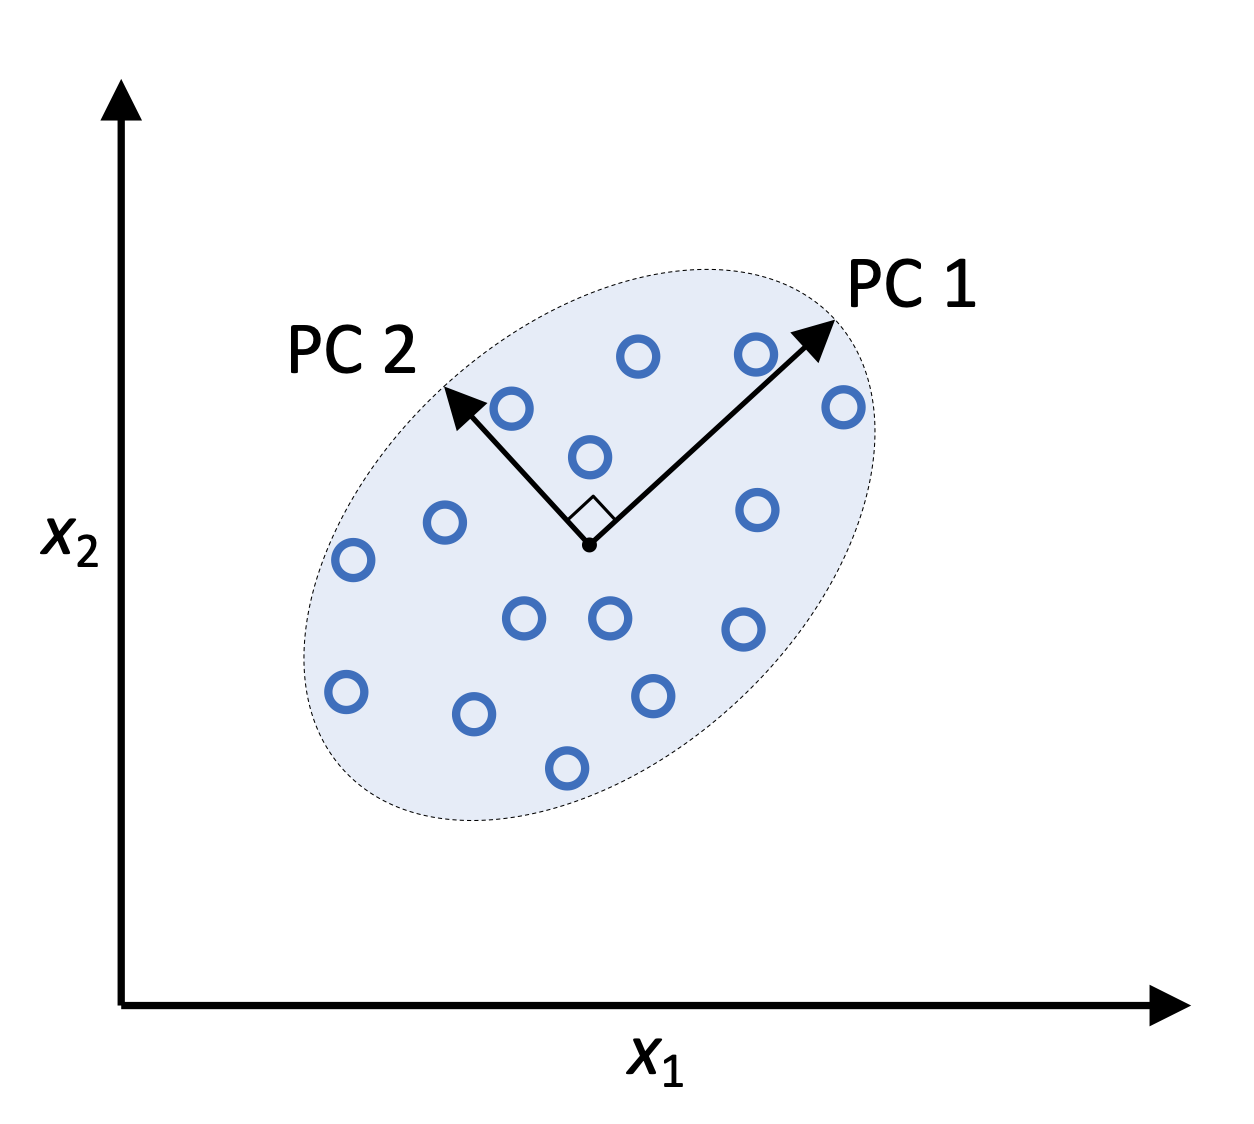

In [1]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter5/figures/05_01.png', 
      width=450)

在上图中, $x_1$和$x_2$是原始特征轴(original feature axes), 同时`PC 1`和`PC 2`是主成分.

当我们使用PCA进行降维处理的时候, 会构建一个$d\times k$维度的转换矩阵$\mathbf{W}$， 利用它就可以将训练样本$x$的特征向量映射到一个新的$k$维特征子空间，该子空间的维度小于原始特征子空间维度$d$。例如：假设有一个特征向量$\boldsymbol{x}$,则：

$$\boldsymbol{x}=[x_1,x_2,...,x_d],\quad \boldsymbol{x}\in\mathbb{R}^d$$

它通过转换矩阵$\mathbf{W}$进行投影，其中$\mathbf{W}\in\mathbb{R}^{d\times k}$，如下：
$$\boldsymbol{x}\mathbf{W}=\boldsymbol{z}$$

在上式中，输出向量满足：
$$\mathbf{z}=[z_{1},z_{2},...,z_{k}],\quad\mathbf{z}\in\mathbb{R}^{k}$$

`需要注意的是，PCA方向对数据尺度高度敏感，因此在进行PCA之前需要进行特征标准化`。

#### 主成分分析的步骤

主成分分析的步骤可以总结如下：

* 对$d$维的待处理数据集进行标准化(Standardize)处理；
* 构建协方差矩阵(Construct the covariance matrix);
* 协方差矩阵分解(Decompose the Covariance matrix), 得到特征值和特征向量(eigenvectors and eigenvalues);
* 按降序对特征值进行排序，包括与其对应的特征向量；
* 选择$k$个最大特征值对应的特征向量，其中$k$是新的特征空间的维度，其满足($k\le d$);
* 利用"top" $k$个特征向量构建投影矩阵$\mathbf{W}$;
* 对$d$维的输入数据$\mathbf{X}$, 利用投影矩阵$\mathbf{W}$进行变换，得到$k$维特征子空间。

#### 利用Python实现主成分分析

In [2]:
# 载入数据.
import pandas as pd

df_wine = pd.read_csv('../Python-MachineLearning/Datasets//Wine_data/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# 数据集拆分.
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, stratify=y, 
                                                    random_state=0)

In [4]:
# 特征标准化.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

协方差矩阵为对称方阵，存储了不同特征之间的成对协方差.对两个特征$x_j$和$x_k$,其计算过程如下：
$$\sigma_{jk}=\frac{1}{n-1}\sum_{i=1}^{n}\bigl(x_{j}^{(i)}-\mu_{j}\bigr)\bigl(x_{k}^{(i)}-\mu_{k}\bigr)$$

其中，$\mu_{j}$和$\mu_{k}$分别是特征$j$和$k$的样本均值。三个特征的协方差矩阵可以写为如下形式：
$$\Sigma=\begin{bmatrix}\sigma_1^2&\sigma_{12}&\sigma_{13}\\\sigma_{21}&\sigma_2^2&\sigma_{23}\\\sigma_{31}&\sigma_{32}&\sigma_3^2\end{bmatrix}$$

协方差矩阵的特征向量表示主成分(方差最大的方向)，而相应的特征值则定义为其大小。 在线形代数中，特征向量满足：
$$\Sigma\boldsymbol{v}=\lambda\boldsymbol{v}$$

其中，$\lambda$是一个标量形式的特征值。

In [5]:
# 构建协方差矩阵并计算特征值和特征向量.
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_values, eigen_vecs  = np.linalg.eig(cov_mat)

print('Eigenvalues', eigen_values)

Eigenvalues [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


#### 总方差和解释方差(Total and explained variance)

为了将数据集压缩到新的特征子空间来降低维度，所以仅需要选择包含大部分信息(variance)的特征向量子集(principal components). 特征值定义了特征向量的大小，因此需要按照降序对特征值进行排序，然后选择前$k$个.

具体地，首先绘制方差解释比例(variance explained ratio), 其定义如下：
$$\text{Explained variance ratio}=\frac{\lambda_j}{\sum_{j=1}^d\lambda_j}$$

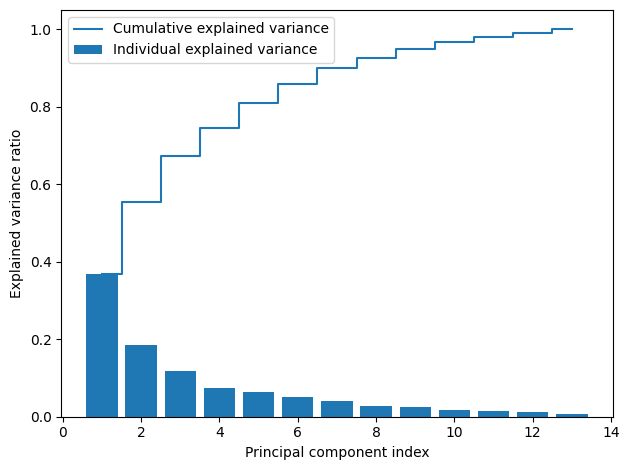

In [6]:
# 绘制方差解释比例(variance explained ratios).
tot = sum(eigen_values)
"""
特征值通常表示主成分分析(PCA)中每个主成分所解释的方差.
"""
var_exp = [(i / tot) for i in 
           sorted(eigen_values, reverse=True)]
"""
首先对每个特征值进行排序，然后计算每个主成分的解释方差比例(即每个特征值与总特征值的比值).
"""
cum_var_exp = np.cumsum(var_exp)
"""
使用numpy中的cumsum函数计算累积解释方差. cum_var_exp中的每个元素表示到当前主成分为止的总
解释方差比例.
"""

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, align='center', 
        label='Individual explained variance')
"""
绘制一个条形图，表示每个主成分的单独解释方差比例.
"""
plt.step(range(1, 14), cum_var_exp, where='mid', 
         label='Cumulative explained variance')
"""
绘制一条阶梯图，表示累积解释方差. where='mid'确保阶梯的变化发生在每个区间的中间位置.
"""

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

生成的图表表明，第一个主成分单独解释了大约40%的方差；此外，前两个主成分一共解释了数据集中近60%的方差.

#### 特征变换

上述过程已经将协方差矩阵分解为特征对(eigenpairs)，为完成特征空间映射，其余步骤如下：

* 选择$k$个最大特征值对应的特征向量，$k$是新特征空间的维度($k\le d$);
* 利用$k$个特征向量构建投影矩阵$\mathbf{W}$;
* 使用投影矩阵对输入数据集$\boldsymbol{X}$进行变换，得到$k$维特征子空间。

In [7]:
# 构建(eigenvalue, eigenvector)元组.
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vecs[:, i])
               for i in range(len(eigen_values))]

# 对eigenpairs进行排序.
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [8]:
print(eigen_pairs[0])

(4.8427453156559, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651]))


接下来，收集与两个最大特征值相对应的两个特征向量，以捕获此数据集中约60%的方差。

In [9]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))

print('The projection matrix W: \n', w)

The projection matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [10]:
# 使用投影矩阵进行特征空间变换. x'=xW
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [11]:
# 推广到整个数据集.
X_train_pca = X_train_std.dot(w)

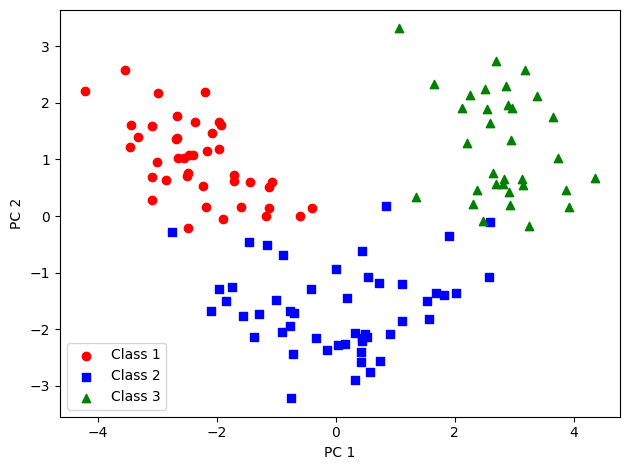

In [12]:
# 可视化变换后的数据集.
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('../Python-MachineLearning/Attached_images/Chapter5/figures/05_03.png', dpi=600)
plt.show()

In [13]:
X_train_pca[y_train == 1, 0]

array([-1.96578183, -2.53907598, -1.43010776, -3.00366211, -1.12276518,
       -1.58427878, -1.71438911, -2.07635784, -2.50372355, -2.19448402,
       -1.11739618, -1.71469178, -2.48581303, -2.38993219, -2.65169609,
       -1.16670455, -2.4858391 , -2.16575568, -2.66783112, -2.67324153,
       -2.36367378, -0.39171875, -2.98908845, -1.91822539, -1.06050503,
       -3.31185057, -2.23205085, -1.88961007, -3.08131761, -3.45716348,
       -3.43344371, -4.20642597, -0.60047516, -3.08276231, -3.07882055,
       -2.84838157, -2.46582558, -2.16983025, -2.66728229, -3.53223924,
       -1.96637688])

#### 使用Sklearn实现主成分分析

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')